Ref: https://levelup.gitconnected.com/building-seq2seq-lstm-with-luong-attention-in-keras-for-time-series-forecasting-1ee00958decb

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Import data

In [21]:
data = pd.read_csv('../data/num_file/min_05/p040.csv')

In [22]:
print(data)

                  datetime  count
0      2022-04-21 01:40:00    200
1      2022-04-21 01:45:00      0
2      2022-04-21 01:50:00    241
3      2022-04-21 01:55:00    592
4      2022-04-21 02:00:00     27
...                    ...    ...
38995  2022-09-03 11:15:00   1042
38996  2022-09-03 11:20:00   1913
38997  2022-09-03 11:25:00   2024
38998  2022-09-03 11:30:00   2006
38999  2022-09-03 11:35:00   2170

[39000 rows x 2 columns]


If there is no people, use NaN.

In [23]:
data.loc[data['count']==0, 'count'] = np.NaN

In [24]:
print(data)

                  datetime   count
0      2022-04-21 01:40:00   200.0
1      2022-04-21 01:45:00     NaN
2      2022-04-21 01:50:00   241.0
3      2022-04-21 01:55:00   592.0
4      2022-04-21 02:00:00    27.0
...                    ...     ...
38995  2022-09-03 11:15:00  1042.0
38996  2022-09-03 11:20:00  1913.0
38997  2022-09-03 11:25:00  2024.0
38998  2022-09-03 11:30:00  2006.0
38999  2022-09-03 11:35:00  2170.0

[39000 rows x 2 columns]


<Axes: >

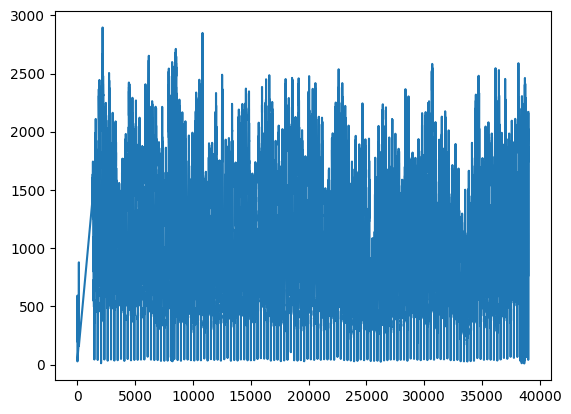

In [25]:
data['count'] = data['count'].interpolate(method='linear')
data['count'].plot()

## Normalize data

<Axes: >

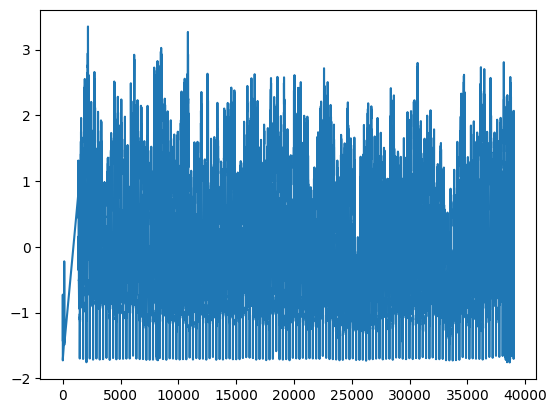

In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data['count'] = scaler.fit_transform(data[['count']])
data['count'].plot()

In [27]:
print(data)

                  datetime     count
0      2022-04-21 01:40:00 -1.420353
1      2022-04-21 01:45:00 -1.384071
2      2022-04-21 01:50:00 -1.347789
3      2022-04-21 01:55:00 -0.726571
4      2022-04-21 02:00:00 -1.726537
...                    ...       ...
38995  2022-09-03 11:15:00  0.069861
38996  2022-09-03 11:20:00  1.611400
38997  2022-09-03 11:25:00  1.807854
38998  2022-09-03 11:30:00  1.775996
38999  2022-09-03 11:35:00  2.066252

[39000 rows x 2 columns]


In [28]:
encode_input_data = []
decode_input_data = []
decode_output_data = []
time_step = 10

for i in range(len(data)-time_step-1):
    encode_input_data.append(data['count'].values[i:i+time_step])
    decode_input_data.append(data['count'].values[i:i+time_step])
    decode_output_data.append(data['count'].values[i+1:i+time_step+1])

encode_input_data = np.array(encode_input_data)
decode_input_data = np.array(decode_input_data)
decode_output_data = np.array(decode_output_data)

In [29]:
encode_input_data = encode_input_data.reshape(encode_input_data.shape[0], encode_input_data.shape[1], 1)
decode_input_data = decode_input_data.reshape(decode_input_data.shape[0], decode_input_data.shape[1], 1)
decode_output_data = decode_output_data.reshape(decode_output_data.shape[0], decode_output_data.shape[1], 1)

In [30]:
train_size = int(len(encode_input_data)*0.8)
encode_input_data_train = encode_input_data[:train_size]
decode_input_data_train = decode_input_data[:train_size]
decode_output_data_train = decode_output_data[:train_size]
encode_input_data_test = encode_input_data[train_size:]
decode_input_data_test = decode_input_data[train_size:]
decode_output_data_test = decode_output_data[train_size:]

## Model

In [31]:
from keras.layers import Input, LSTM, BatchNormalization, RepeatVector, TimeDistributed, Dense, dot, multiply, concatenate, Activation
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [32]:
input_train = Input(shape=(time_step, 1))
output_train = Input(shape=(time_step, 1))

In [33]:
encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(32, activation='relu', return_sequences=False, return_state=True)(input_train)

In [34]:
encoder_last_h1 = BatchNormalization()(encoder_last_h1)
encoder_last_c = BatchNormalization()(encoder_last_c)

In [35]:
decoder = RepeatVector(time_step)(encoder_last_h1)
decoder = LSTM(32, activation='relu', return_state=False, return_sequences=True)(decoder, initial_state=[encoder_last_h1, encoder_last_c])

In [36]:
out = TimeDistributed(Dense(1))(decoder)

In [37]:
model = Model(inputs=input_train, outputs=out)
opt = Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 32),      │      4,352 │ input_layer_2[0]… │
│                     │ (None, 32),       │            │                   │
│                     │ (None, 32)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ lstm_2[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 10, 32)    │          0 │ batch_normalizat… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ lstm_2[0][2]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 10, 32)    │      8,320 │ repeat_vector_1[… │
│                     │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 10, 1)     │         33 │ lstm_3[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,961 (50.63 KB)

 Trainable params: 12,833 (50.13 KB)

 Non-trainable params: 128 (512.00 B)

In [38]:
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
history = model.fit(encode_input_data_train, decode_output_data_train, epochs=100, batch_size=128, validation_split=0.1, callbacks=[es])

Epoch 1/100


220/220 ━━━━━━━━━━━━━━━━━━━━ 42s 177ms/step - loss: 0.1338 - mae: 0.2229 - val_loss: 0.3435 - val_mae: 0.5043
Epoch 2/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 36s 165ms/step - loss: 0.0323 - mae: 0.1303 - val_loss: 0.0761 - val_mae: 0.2264
Epoch 3/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 37s 168ms/step - loss: 0.0299 - mae: 0.1221 - val_loss: 0.0283 - val_mae: 0.1256
Epoch 4/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 38s 174ms/step - loss: 0.0270 - mae: 0.1134 - val_loss: 0.0246 - val_mae: 0.1129
Epoch 5/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 41s 188ms/step - loss: 0.0243 - mae: 0.1095 - val_loss: 0.0341 - val_mae: 0.1286
Epoch 6/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 41s 189ms/step - loss: 0.0209 - mae: 0.1009 - val_loss: 0.0231 - val_mae: 0.1121
Epoch 7/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 42s 190ms/step - loss: 0.0206 - mae: 0.1009 - val_loss: 0.0327 - val_mae: 0.1332
Epoch 8/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 41s 185ms/step - loss: 0.0200 - mae: 0.0995 - val_loss: 0.0257 - val_mae: 0.1119
Epoch 9/100
220/220 ━━━━━━━━━━━━━━━━

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


In [ ]:
predict_train = model.predict(encode_input_data_train)

In [ ]:
predict_test = model.predict(encode_input_data_test)

In [ ]:
print(predict_train.shape)

In [ ]:
print(predict_test.shape)

In [ ]:
predict = np.concatenate([predict_train, predict_test], axis=0)
print(predict.shape)

In [ ]:
print(predict_test[:, -1, :])

In [ ]:
print(decode_output_data_test[:, -1, :])

In [ ]:
plt.plot(np.arange(decode_output_data_test.shape[0]), decode_output_data_test[:, -1, :])
plt.plot(np.arange(predict_test.shape[0]), predict_test[:, -1, :])
plt.show()

In [ ]:
predict_test_data = scaler.inverse_transform(predict_test[:, -1, :])
decode_output_test_data = scaler.inverse_transform(decode_output_data_test[:, -1, :])
plt.plot(np.arange(decode_output_test_data.shape[0]), decode_output_test_data)
plt.plot(np.arange(predict_test_data.shape[0]), predict_test_data)
plt.title(f'MAE: {np.mean(np.abs((predict_test_data-decode_output_test_data)/decode_output_test_data))}')
plt.show()

## Attention

In [ ]:
input_train = Input(shape=(time_step, 1))
output_train = Input(shape=(time_step, 1))

In [ ]:
encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(32, activation='relu', return_sequences=True, return_state=True)(input_train)
print(encoder_stack_h)
print(encoder_last_h)
print(encoder_last_c)

In [ ]:
encoder_last_h = BatchNormalization()(encoder_last_h)
encoder_last_c = BatchNormalization()(encoder_last_c)

In [ ]:
decoder_input = RepeatVector(time_step)(encoder_last_h)
print(decoder_input)

In [ ]:
decoder_stack_h = LSTM(32, activation='relu', return_sequences=True)(decoder_input, initial_state=[encoder_last_h, encoder_last_c])
print(decoder_stack_h)

In [ ]:
attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])

In [ ]:
attention = Activation('softmax')(attention)

In [ ]:
print(attention)

In [ ]:
context = dot([attention, encoder_stack_h], axes=[2, 1])
context = BatchNormalization()(context)
print(context)

In [ ]:
decoder_combined_context = concatenate([context, decoder_stack_h])
print(decoder_combined_context)

In [ ]:
out = TimeDistributed(Dense(1))(decoder_combined_context)
print(out)

In [ ]:
model = Model(inputs=input_train, outputs=out)
opt = Adam(learning_rate=0.01, clipnorm=1.0)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

In [ ]:
history = model.fit(encode_input_data_train, decode_output_data_train, epochs=100, batch_size=128, validation_split=0.1, callbacks=[es])

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()


In [ ]:
predict_test = model.predict(encode_input_data_test)

In [ ]:
predict_test_data = scaler.inverse_transform(predict_test[:, -1, :])

In [ ]:
plt.plot(np.arange(decode_output_test_data.shape[0]), decode_output_test_data)
plt.plot(np.arange(predict_test_data.shape[0]), predict_test_data)
plt.title(f'MAE: {np.mean(np.abs((predict_test_data-decode_output_test_data)/decode_output_test_data))}')
plt.show()

In [ ]:
print(predict_test_data)

In [ ]:
print(decode_output_test_data)